In [1]:
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib
import torchvision
import torch
import os
import random
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, auc, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from collections import defaultdict
from pathlib import Path
import gc
import pickle
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
#from tasksim import *
import seaborn as sns
sns.set()

from joblib import Parallel, delayed
import time


matplotlib.style.use('ggplot')

In [2]:
class IconDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform, data_root, run, label_noise):
        self.class_names = df['class'].unique().tolist()
        self.image_dir = data_root
        self.transform = transform
        self.total = len(df)
        self.image_names = df['image_path'].to_list()
        self.labels = df['%s_%s' %(run, label_noise)].to_numpy()
        self.targets = self.labels
                    
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = self.transform(Image.open(image_path).convert('RGB'))
        label = self.labels[idx]
        target = self.labels[idx]
        return image, label

    
image_size = (128, 128)
resnet_mean = [0.485, 0.456, 0.406]
resnet_std = [0.229, 0.224, 0.225]

#Creating a Transformation Object
train_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=image_size),
    torchvision.transforms.RandomHorizontalFlip(), #A RandomHorizontalFlip to augment our data
    torchvision.transforms.ToTensor(), #Converting to tensor
    #Normalizing the data to the data that the ResNet18 was trained on
    torchvision.transforms.Normalize(mean = resnet_mean ,
                                    std = resnet_std) 
    
])


#Creating a Transformation Object
test_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=image_size),
    # We don't do data augmentation in the test/val set    
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = resnet_mean,
                                    std = resnet_std) 
    
])

#build model using Resnext50 as backbone
class Resnext50(torch.nn.Module):
    def __init__(self, n_classes, name):
        super().__init__()
        self.name = name
        resnet = torchvision.models.resnext50_32x4d(pretrained=True, progress=True)
        resnet.fc = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.soft = torch.nn.Softmax(dim=1)

    def forward(self, x):
        return self.soft(self.base_model(x))

def train_loop(dataloader, model, loss_fn, optimizer, mode="flat", lookup=[], fine_to_coarse={}, 
               batch_size=64):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    counter = 0
    with tqdm(dataloader, unit="batch") as tepoch:
        for X_cpu, y_cpu in tepoch:
            counter += 1
            if mode == "fine":
                y_cpu = torch.tensor([lookup.index(i) for i in y_cpu])
            elif mode == "coarse":
                y_cpu = torch.tensor([fine_to_coarse[int(target)] for target in y_cpu])
            X, y = X_cpu.to(device), y_cpu.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_fn(outputs, y.type(torch.long))
            loss.backward() 
            optimizer.step() 
            train_loss += loss.item() 
            avg_loss = train_loss / counter
            tepoch.set_postfix(loss=avg_loss)
    return avg_loss
    
    
def eval_model(dataloader, model, loss_fn, mode="flat", lookup=[], fine_to_coarse={}, 
               return_probab=False, batch_size=64):
    model.eval()
    predicts = []
    targets = []
    val_running_loss = 0.0
    
    for counter, (images, labels) in enumerate(dataloader):
        if mode == "fine":
            labels = torch.tensor([lookup.index(i) for i in labels])
        elif mode == "coarse":
            labels = torch.tensor([fine_to_coarse[int(i)] for i in labels])
        else:
            labels = torch.tensor(labels)
        imageGPU = images.to(device)
        
        outputs = torch.Tensor.cpu(model(imageGPU))
        loss = loss_fn(outputs, labels.type(torch.long))
        val_running_loss += loss.item()
        predicts.append(outputs.detach().numpy())
        targets.append(labels)
    val_loss = val_running_loss / counter  
    predicts = np.vstack(predicts)
    targets = np.hstack(targets)
    if return_probab:
        return predicts, targets
    else:
        predicts = np.argmax(predicts, axis=1)
        return val_loss, accuracy_score(targets, predicts)

    

def train_and_validate(epochs, model, loss_fn, optimizer, train_dl, test_dl, val_dl,
                       mode="flat", fine_to_coarse={}, coarse_label=None, lookup=[], 
                       model_path = None):

    early_stopping=EarlyStopping()
    #lr_scheduler = LRScheduler(optimizer)
    
    if model_path is None:
        model_path = '/models/%s.pth' %model.name
    min_loss= 1000
    max_acc = 0
    train_loss= []
    val_loss, val_accuracy = [], []
    for t in range(epochs):
        if mode == "fine":
            print(f"Coarse label {coarse_label} Epoch {t+1}\n-------------------------------")
        else:
            print(f"Epoch {t+1}\n-------------------------------")
        train_epoch_loss = train_loop(train_dl, model, loss_fn, optimizer, mode=mode, fine_to_coarse=fine_to_coarse, lookup=lookup)
        val_epoch_loss, val_epoch_acc = eval_model(val_dl, model,loss_fn, mode=mode, fine_to_coarse=fine_to_coarse, lookup=lookup)
        
        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_acc)
        if val_epoch_loss < min_loss:
            max_acc = val_epoch_acc
            min_loss = val_epoch_loss
            torch.save(model.state_dict(), model_path)
        elif val_epoch_acc>max_acc:
            max_acc = val_epoch_acc
            torch.save(model.state_dict(), model_path)
        early_stopping(val_epoch_loss)
        if early_stopping.early_stop:
            break
        print("train loss %s, validation loss %s, validation accuracy %s" %(train_epoch_loss, 
                                                                            val_epoch_loss, 
                                                                            val_epoch_acc))
    test_loss, test_acc = eval_model(test_dl, model, loss_fn, mode=mode, fine_to_coarse=fine_to_coarse, lookup=lookup)
    print("Done! Saved model with test accuracy %s and loss %s" %(test_acc, test_loss))
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(val_accuracy, color='blue', label='validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"models/validationAccuracy{model.name}.png")
    plt.show()
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(val_loss, color='red', label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"models/losses{model.name}.png")
    plt.show()
    
    return  test_acc


class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True



In [7]:
#learning rate is the same for all models
learning_rate = 1e-4 
teamdrive_root = '../../../../teamdrive/transmediasp/kate/'
fine_tuned_model_path = teamdrive_root + 'icons_experiment/icons_fine_tuned_model.pth'

label_noises = [0, 10, 20, 30, 50, 80]
seeds = [5965, 6782, 5025, 9042, 3650, 7505, 5064, 2678, 6805, 1640]

#create a dictionary to save results in
flat_accuracies = defaultdict()

In [4]:
#load dataframe with labels
df = pd.read_csv(teamdrive_root + 'icons_experiment/data_frame_50_percent_splits_with_label_noise.csv', index_col=0)

n_classes = len(df['class'].unique())
df.head(5)

,image_path,class,label,split_0,split_1,split_2,split_3,split_4,split_5,split_6,...,8_20,8_30,8_50,8_80,9_0,9_10,9_20,9_30,9_50,9_80
0,../../../data/testdotai/close/_e4530e1aae88750...,close,0,train,train,test,test,train,valid,test,...,17,17,17,17,0,0,0,0,88,88
1,../../../data/testdotai/close/~02a0c54fd8374b4...,close,0,test,train,test,test,train,test,train,...,0,0,0,42,0,0,0,88,38,38
2,../../../data/testdotai/close/_10099f88fd8333f...,close,0,train,train,test,test,train,train,test,...,0,0,42,13,0,88,88,38,8,8
3,../../../data/testdotai/close/_bcd740021f1a62a...,close,0,test,test,train,test,train,test,test,...,0,0,0,0,0,0,0,8,74,74
4,../../../data/testdotai/close/_047b3f69c7c53b8...,close,0,train,test,test,train,train,train,train,...,0,0,0,0,0,0,0,0,0,0


In [5]:
torch.cuda.is_available()

if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
    
device = torch.device(dev)  


0 0
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.09]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.093947183043332, validation loss 4.0139480989712935, validation accuracy 0.5910313901345291
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [06:02<00:00,  2.90batch/s, loss=3.94]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9431454419183187, validation loss 3.9628463914761176, validation accuracy 0.6411061285500748
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [07:44<00:00,  2.26batch/s, loss=3.91]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.907719051203347, validation loss 3.9239280246771298, validation accuracy 0.6816143497757847
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [06:01<00:00,  2.91batch/s, loss=3.87]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8655246824819325, validation loss 3.908081304568511, validation accuracy 0.6956651718983557
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [06:02<00:00,  2.90batch/s, loss=3.85]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.849302163368849, validation loss 3.8955944111713996, validation accuracy 0.7083707025411061
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [06:01<00:00,  2.91batch/s, loss=3.84]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.836061730584264, validation loss 3.875641637123548, validation accuracy 0.7278026905829597
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [06:00<00:00,  2.92batch/s, loss=3.83]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 1 of 5
train loss 3.8251145837878093, validation loss 3.8779076681687283, validation accuracy 0.7252615844544096
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [06:00<00:00,  2.92batch/s, loss=3.82]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8190669179415977, validation loss 3.8737891889535465, validation accuracy 0.728101644245142
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [07:40<00:00,  2.28batch/s, loss=3.81]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8145110573152174, validation loss 3.8730197778114905, validation accuracy 0.7301943198804185
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [06:00<00:00,  2.92batch/s, loss=3.81]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.811192828892755, validation loss 3.8626067546697764, validation accuracy 0.7402092675635277
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [07:39<00:00,  2.29batch/s, loss=3.8]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.7955184776066826, validation loss 3.8540958211972165, validation accuracy 0.7466367713004485
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [06:01<00:00,  2.91batch/s, loss=3.79]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.7861283632285696, validation loss 3.852528303861618, validation accuracy 0.7491778774289986
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [06:01<00:00,  2.91batch/s, loss=3.78]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 2 of 5
train loss 3.7827139734768593, validation loss 3.855178427237731, validation accuracy 0.7475336322869955
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [05:59<00:00,  2.93batch/s, loss=3.78]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.7811861847290067, validation loss 3.8449848821529975, validation accuracy 0.7566517189835575
Epoch 15
-------------------------------


100%|██████████| 1052/1052 [05:59<00:00,  2.92batch/s, loss=3.78]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 3 of 5
train loss 3.7770805098258045, validation loss 3.8490372621096096, validation accuracy 0.7515695067264574
Epoch 16
-------------------------------


100%|██████████| 1052/1052 [05:59<00:00,  2.93batch/s, loss=3.77]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 4 of 5
train loss 3.7733726886742014, validation loss 3.845697840818992, validation accuracy 0.7556053811659192
Epoch 17
-------------------------------


100%|██████████| 1052/1052 [06:01<00:00,  2.91batch/s, loss=3.77]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 5 of 5
INFO: Early stopping


<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Done! Saved model with test accuracy 0.7559430522790637 and loss 3.811008202614225


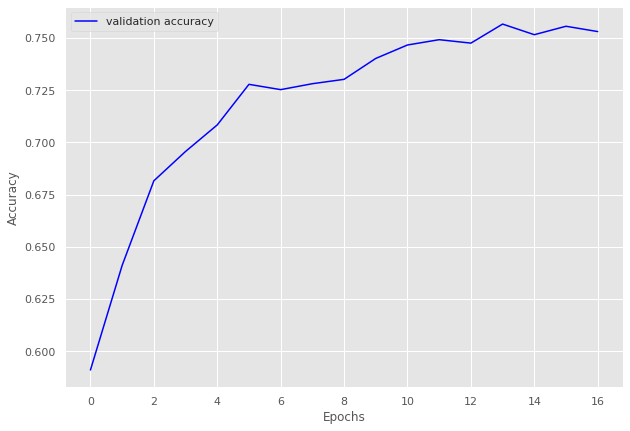

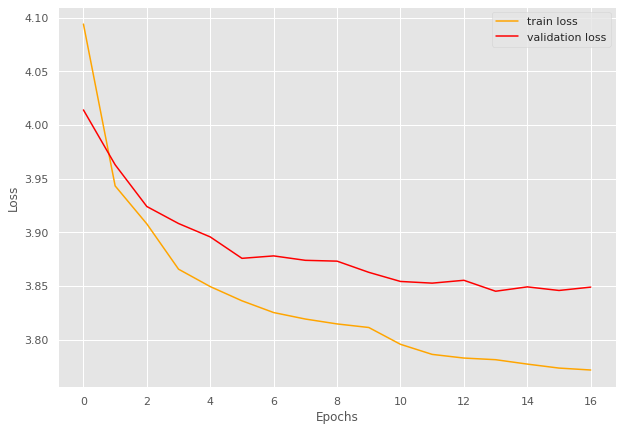

defaultdict(None, {'0': defaultdict(None, {'0': 0.7559430522790637})})
0 10
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [05:59<00:00,  2.92batch/s, loss=4.15]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.150927548626076, validation loss 4.100191462498445, validation accuracy 0.5062780269058296
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [06:00<00:00,  2.92batch/s, loss=4.01]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.011071914049156, validation loss 4.0360924028433285, validation accuracy 0.5689088191330344
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [07:36<00:00,  2.30batch/s, loss=3.97]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.974775775757126, validation loss 4.008812177639741, validation accuracy 0.5944693572496264
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [06:01<00:00,  2.91batch/s, loss=3.95]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9484472249850575, validation loss 3.98986423932589, validation accuracy 0.6131539611360239
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [06:07<00:00,  2.86batch/s, loss=3.93]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.929440971563071, validation loss 3.9796119515712443, validation accuracy 0.6237668161434977
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.92]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9159639649971356, validation loss 3.9653960260061116, validation accuracy 0.63796711509716
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.91]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9062874591395884, validation loss 3.963035157093635, validation accuracy 0.6411061285500748
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [09:19<00:00,  1.88batch/s, loss=3.9]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.897798232705874, validation loss 3.951472119643138, validation accuracy 0.6529147982062781
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.89]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.889253837754065, validation loss 3.948724781091397, validation accuracy 0.654559043348281
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.88]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.884435097980862, validation loss 3.944718138529704, validation accuracy 0.6576980568011959
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [07:54<00:00,  2.22batch/s, loss=3.87]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.874034494048289, validation loss 3.937377067712637, validation accuracy 0.6645739910313901
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.87]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.866815601691547, validation loss 3.92886397930292, validation accuracy 0.6732436472346787
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [06:07<00:00,  2.86batch/s, loss=3.86]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8606922699018122, validation loss 3.923106768956551, validation accuracy 0.6790732436472346
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=3.85]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8527913732673733, validation loss 3.9162641626137953, validation accuracy 0.6860986547085202
Epoch 15
-------------------------------


100%|██████████| 1052/1052 [07:45<00:00,  2.26batch/s, loss=3.85]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 1 of 5
train loss 3.8505207662799967, validation loss 3.9240819903520436, validation accuracy 0.6778774289985052
Epoch 16
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.87batch/s, loss=3.85]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 2 of 5
train loss 3.850120687892682, validation loss 3.917846613205396, validation accuracy 0.6831091180866966
Epoch 17
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.85]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8478284342207383, validation loss 3.9156106527035055, validation accuracy 0.6866965620328849
Epoch 18
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.87batch/s, loss=3.84]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 3 of 5
train loss 3.8449161324664214, validation loss 3.9158283793009243, validation accuracy 0.6860986547085202
Epoch 19
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.84]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 4 of 5
train loss 3.8443532955510533, validation loss 3.915918753697322, validation accuracy 0.6863976083707025
Epoch 20
-------------------------------


100%|██████████| 1052/1052 [07:47<00:00,  2.25batch/s, loss=3.84]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8415598429654487, validation loss 3.9096213051906, validation accuracy 0.691778774289985
Epoch 21
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.84]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8380231000624683, validation loss 3.9084321535550632, validation accuracy 0.6935724962630793
Epoch 22
-------------------------------


100%|██████████| 1052/1052 [06:07<00:00,  2.86batch/s, loss=3.84]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8355988386466024, validation loss 3.9077350061673384, validation accuracy 0.6938714499252616
Epoch 23
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=3.83]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8287861242947017, validation loss 3.9021690258613, validation accuracy 0.7004484304932735
Epoch 24
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.83]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 5 of 5
INFO: Early stopping


<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Done! Saved model with test accuracy 0.770031509312569 and loss 3.7969519145385515


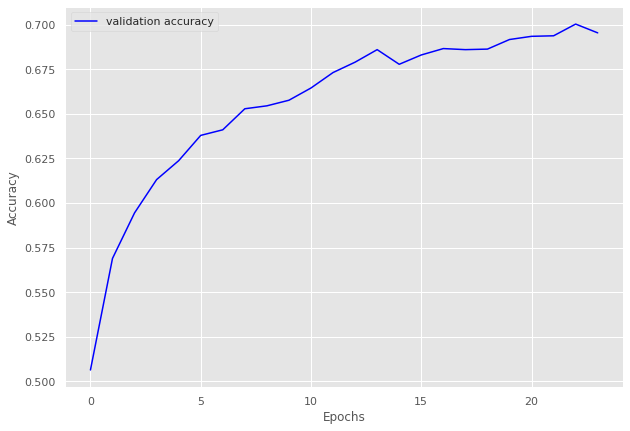

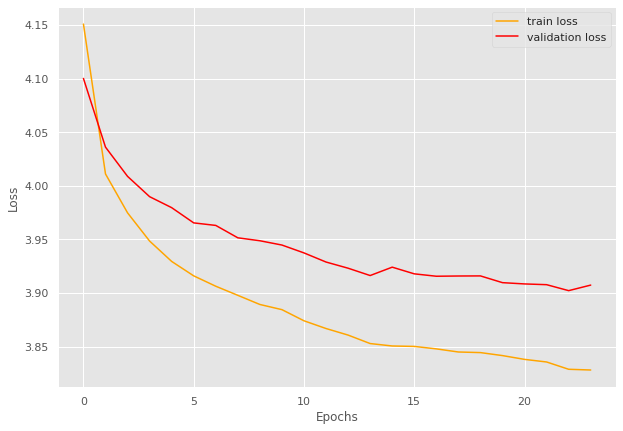

defaultdict(None, {'0': defaultdict(None, {'0': 0.7559430522790637, '10': 0.770031509312569})})
0 20
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4.2] 
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.20393841960131, validation loss 4.148705718609003, validation accuracy 0.4571001494768311
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.87batch/s, loss=4.07]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.072683352028009, validation loss 4.105935071523373, validation accuracy 0.4994020926756353
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.03]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.034034480613448, validation loss 4.077012836933136, validation accuracy 0.5272047832585949
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=4.02]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.016335432293751, validation loss 4.074458603675549, validation accuracy 0.5306427503736921
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4] 
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.002818091060726, validation loss 4.0511056161843815, validation accuracy 0.5532137518684603
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [07:46<00:00,  2.26batch/s, loss=3.98]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9810941072017973, validation loss 4.0371747727577505, validation accuracy 0.5663677130044843
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [06:08<00:00,  2.86batch/s, loss=3.97]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9695032093914744, validation loss 4.034657955169678, validation accuracy 0.569357249626308
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.96]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9631148721781972, validation loss 4.028342285981545, validation accuracy 0.5756352765321375
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.96]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.961128527447298, validation loss 4.027829454495357, validation accuracy 0.5751868460388639
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [07:45<00:00,  2.26batch/s, loss=3.95]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.952438486619594, validation loss 4.012720183684276, validation accuracy 0.5889387144992526
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.89batch/s, loss=3.95]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9453404969588886, validation loss 4.0061167020064135, validation accuracy 0.5958146487294469
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.93]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9345842488818294, validation loss 4.000448385110269, validation accuracy 0.6011958146487294
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [07:48<00:00,  2.25batch/s, loss=3.93]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9259484491874055, validation loss 3.999732975776379, validation accuracy 0.601644245142003
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.92]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.922020108527557, validation loss 3.99594217309585, validation accuracy 0.6064275037369208
Epoch 15
-------------------------------


100%|██████████| 1052/1052 [06:07<00:00,  2.86batch/s, loss=3.92]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.915545600675358, validation loss 3.989324296896274, validation accuracy 0.6133034379671151
Epoch 16
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.91]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9118729496636773, validation loss 3.98504517857845, validation accuracy 0.6170403587443947
Epoch 17
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.91]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.909030212648921, validation loss 3.982014550612523, validation accuracy 0.6201793721973095
Epoch 18
-------------------------------


100%|██████████| 1052/1052 [07:48<00:00,  2.25batch/s, loss=3.9] 
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 1 of 5
train loss 3.9044380634456535, validation loss 3.9827211499214172, validation accuracy 0.6191330343796712
Epoch 19
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.9]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 2 of 5
train loss 3.9035757999909695, validation loss 3.9830433978484225, validation accuracy 0.6182361733931241
Epoch 20
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.9]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.899983898541773, validation loss 3.9740158709195943, validation accuracy 0.6289985052316891
Epoch 21
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.9]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 3 of 5
train loss 3.896938594575164, validation loss 3.9838978808659773, validation accuracy 0.6185351270553064
Epoch 22
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.9]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 4 of 5
train loss 3.897292105870555, validation loss 3.9788312797362986, validation accuracy 0.6237668161434977
Epoch 23
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.9] 
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 5 of 5
INFO: Early stopping


<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Done! Saved model with test accuracy 0.7847468531929986 and loss 3.7826958430228794


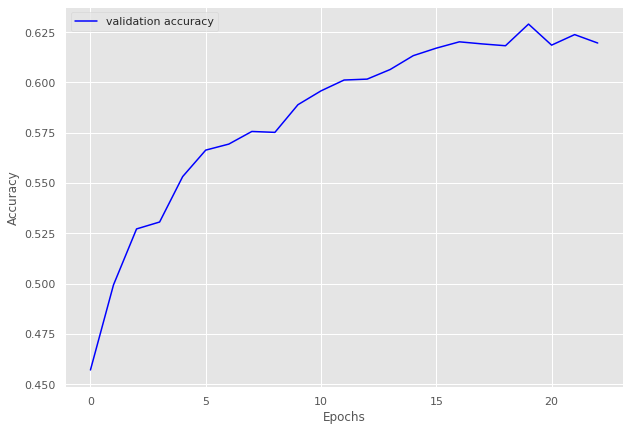

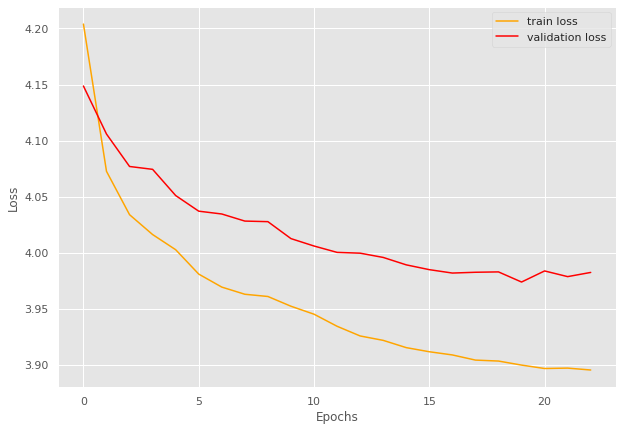

defaultdict(None, {'0': defaultdict(None, {'0': 0.7559430522790637, '10': 0.770031509312569, '20': 0.7847468531929986})})
0 30
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [06:08<00:00,  2.86batch/s, loss=4.25]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.249603892233888, validation loss 4.205355774897796, validation accuracy 0.4007473841554559
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.15]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.1484131949029495, validation loss 4.1792247364154225, validation accuracy 0.42511210762331836
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.12]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.119941513121355, validation loss 4.163090105240162, validation accuracy 0.4415545590433483
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [06:11<00:00,  2.83batch/s, loss=4.1]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.100510663859291, validation loss 4.14957636824021, validation accuracy 0.45485799701046337
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [07:25<00:00,  2.36batch/s, loss=4.08]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.082260490596974, validation loss 4.137746464747649, validation accuracy 0.4657698056801196
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.07]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.066946965886613, validation loss 4.126702785491943, validation accuracy 0.4772795216741405
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [07:22<00:00,  2.38batch/s, loss=4.06]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.058703923180076, validation loss 4.122077675966116, validation accuracy 0.4832585949177877
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4.05]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.052388864098393, validation loss 4.108576912146348, validation accuracy 0.49491778774289985
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=4.04]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.04014699971268, validation loss 4.100471448439818, validation accuracy 0.5026905829596413
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4.03]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.031781353877978, validation loss 4.093662855716852, validation accuracy 0.5085201793721973
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [07:48<00:00,  2.24batch/s, loss=4.03]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.0251595826656645, validation loss 4.089153425051616, validation accuracy 0.514050822122571
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.02]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.021512506352631, validation loss 4.087076847369854, validation accuracy 0.5159940209267564
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.87batch/s, loss=4.02]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.016612299721504, validation loss 4.0854246112016535, validation accuracy 0.5174887892376682
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.01]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.012897916619768, validation loss 4.0797282847074365, validation accuracy 0.5224215246636771
Epoch 15
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.01]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 1 of 5
train loss 4.008260961041251, validation loss 4.081473075426542, validation accuracy 0.5219730941704036
Epoch 16
-------------------------------


100%|██████████| 1052/1052 [07:48<00:00,  2.24batch/s, loss=4]  
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.0020474938838655, validation loss 4.074384863560017, validation accuracy 0.5285500747384155
Epoch 17
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4]  
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9984470676106647, validation loss 4.072872086213185, validation accuracy 0.5301943198804185
Epoch 18
-------------------------------


100%|██████████| 1052/1052 [06:08<00:00,  2.85batch/s, loss=4]  
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.997381378715936, validation loss 4.06940187399204, validation accuracy 0.5327354260089686
Epoch 19
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4]   
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 2 of 5
train loss 3.995259080322976, validation loss 4.072330218095046, validation accuracy 0.531390134529148
Epoch 20
-------------------------------


100%|██████████| 1052/1052 [06:48<00:00,  2.57batch/s, loss=3.99]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 3 of 5
train loss 3.9939182337246013, validation loss 4.069562157759299, validation accuracy 0.5331838565022422
Epoch 21
-------------------------------


100%|██████████| 1052/1052 [06:30<00:00,  2.69batch/s, loss=3.99]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.991836347507433, validation loss 4.066940564375657, validation accuracy 0.5364723467862481
Epoch 22
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.99]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.989375687144102, validation loss 4.066575158100862, validation accuracy 0.5358744394618834
Epoch 23
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.99]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 4 of 5
train loss 3.989571934870441, validation loss 4.072670413897588, validation accuracy 0.5304932735426009
Epoch 24
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.87batch/s, loss=3.99]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 5 of 5
INFO: Early stopping


<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Done! Saved model with test accuracy 0.7636471616873154 and loss 3.8038267253444715


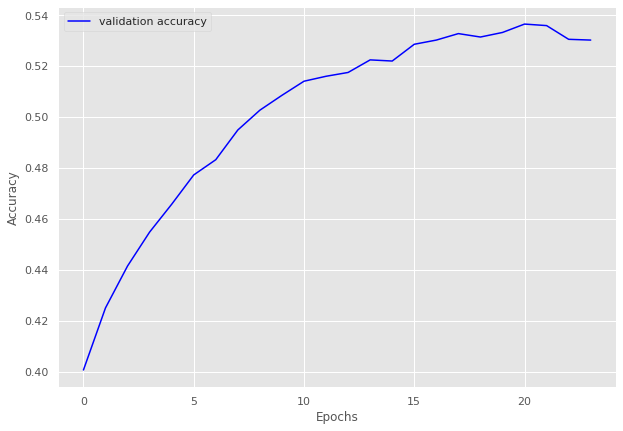

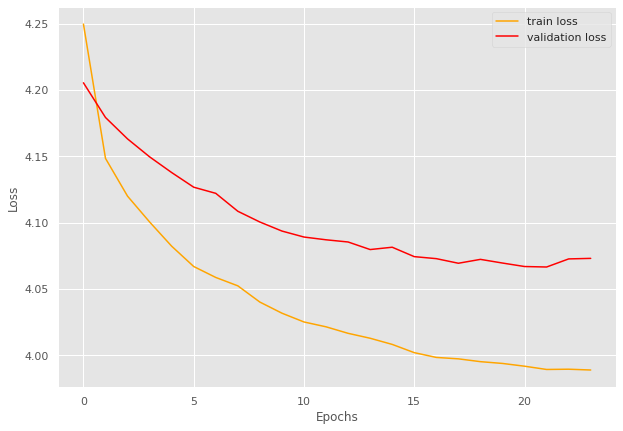

defaultdict(None, {'0': defaultdict(None, {'0': 0.7559430522790637, '10': 0.770031509312569, '20': 0.7847468531929986, '30': 0.7636471616873154})})
0 50
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [07:07<00:00,  2.46batch/s, loss=4.37]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.366361130779687, validation loss 4.367679139742484, validation accuracy 0.2384155455904335
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4.29]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.294139018983442, validation loss 4.334481496077317, validation accuracy 0.27085201793721975
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [06:08<00:00,  2.86batch/s, loss=4.27]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.267424093906417, validation loss 4.3160344683207, validation accuracy 0.28863976083707027
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4.25]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.251559026341021, validation loss 4.301763007274041, validation accuracy 0.30328849028400595
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [06:28<00:00,  2.71batch/s, loss=4.24]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.23534533596764, validation loss 4.292210578918457, validation accuracy 0.31270553064275036
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [06:47<00:00,  2.58batch/s, loss=4.23]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.226615683434128, validation loss 4.286082980724482, validation accuracy 0.31823617339312404
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=4.22]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 1 of 5
train loss 4.223552723347914, validation loss 4.291819159801189, validation accuracy 0.3118086696562033
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.22]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.219044168639092, validation loss 4.28310517164377, validation accuracy 0.3219730941704036
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [07:49<00:00,  2.24batch/s, loss=4.21]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.211166880429924, validation loss 4.268708538550597, validation accuracy 0.3349775784753363
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=4.2]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.19722711632007, validation loss 4.26301154265037, validation accuracy 0.34035874439461883
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [06:09<00:00,  2.85batch/s, loss=4.19]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.190758259577443, validation loss 4.2594123895351705, validation accuracy 0.34424514200298956
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4.19]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.185467237982007, validation loss 4.255322623711366, validation accuracy 0.34857997010463376
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [07:46<00:00,  2.26batch/s, loss=4.18]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.181146038575771, validation loss 4.253536501756082, validation accuracy 0.3508221225710015
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4.18]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.177651239891922, validation loss 4.25211670077764, validation accuracy 0.35201793721973096
Epoch 15
-------------------------------


100%|██████████| 1052/1052 [06:10<00:00,  2.84batch/s, loss=4.17]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.174178498326146, validation loss 4.251317702806913, validation accuracy 0.3523168908819133
Epoch 16
-------------------------------


100%|██████████| 1052/1052 [06:10<00:00,  2.84batch/s, loss=4.17]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.171516202248548, validation loss 4.248830375763086, validation accuracy 0.3536621823617339
Epoch 17
-------------------------------


100%|██████████| 1052/1052 [06:07<00:00,  2.87batch/s, loss=4.17]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.16882260851987, validation loss 4.247335541706819, validation accuracy 0.356203288490284
Epoch 18
-------------------------------


100%|██████████| 1052/1052 [07:45<00:00,  2.26batch/s, loss=4.17]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 2 of 5
train loss 4.169908513587691, validation loss 4.248014727464089, validation accuracy 0.35650224215246634
Epoch 19
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4.17]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.166012923300493, validation loss 4.243799991332567, validation accuracy 0.3600896860986547
Epoch 20
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.89batch/s, loss=4.16]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 3 of 5
train loss 4.163673381388414, validation loss 4.247700872329565, validation accuracy 0.3553064275037369
Epoch 21
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4.16]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 4 of 5
train loss 4.164569963520471, validation loss 4.246883000318821, validation accuracy 0.35754857997010464
Epoch 22
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=4.16]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 5 of 5
INFO: Early stopping


<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Done! Saved model with test accuracy 0.7221571506343105 and loss 3.845173149703045


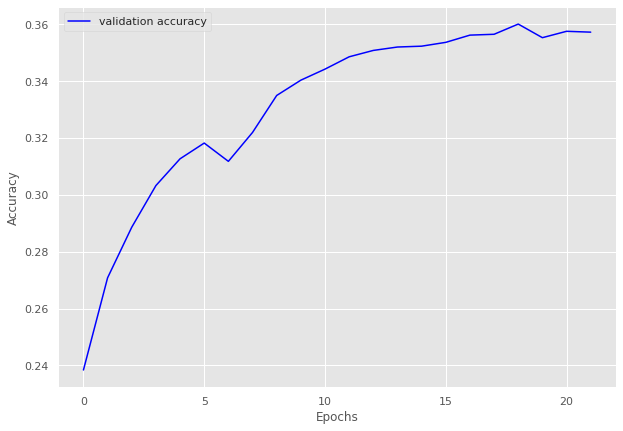

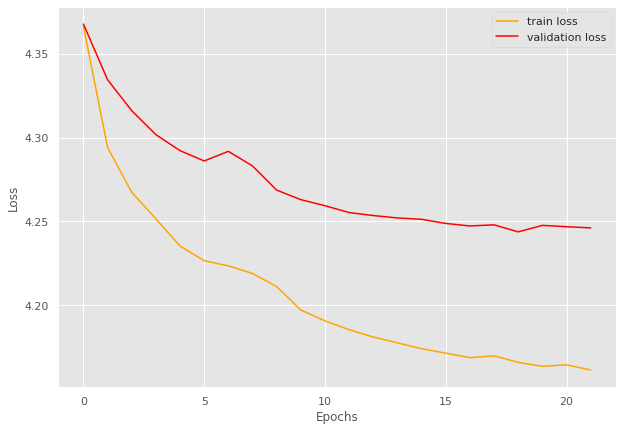

defaultdict(None, {'0': defaultdict(None, {'0': 0.7559430522790637, '10': 0.770031509312569, '20': 0.7847468531929986, '30': 0.7636471616873154, '50': 0.7221571506343105})})
0 80
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.51]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.50920949961296, validation loss 4.5314387037203865, validation accuracy 0.07414050822122571
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=4.48]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.4832213622988855, validation loss 4.521078637013068, validation accuracy 0.08295964125560538
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [06:09<00:00,  2.85batch/s, loss=4.47]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.469949798892206, validation loss 4.513180141265575, validation accuracy 0.09103139013452914
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4.46]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.460949584105169, validation loss 4.501469506667211, validation accuracy 0.10358744394618834
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [06:13<00:00,  2.81batch/s, loss=4.45]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.452741394478105, validation loss 4.500453664706304, validation accuracy 0.10358744394618834
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [07:18<00:00,  2.40batch/s, loss=4.45]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.446407751438736, validation loss 4.490052741307479, validation accuracy 0.114050822122571
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=4.44]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.438127506821781, validation loss 4.485671983315394, validation accuracy 0.11943198804185351
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.43]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.431812315839325, validation loss 4.484366238117218, validation accuracy 0.1203288490284006
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [07:49<00:00,  2.24batch/s, loss=4.43]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.430121772189557, validation loss 4.481870995118068, validation accuracy 0.12257100149476831
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.43]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.4251640636204765, validation loss 4.478854986337515, validation accuracy 0.1257100149476831
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=4.42]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.421952779755393, validation loss 4.475799450507531, validation accuracy 0.12869955156950671
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [06:07<00:00,  2.86batch/s, loss=4.42]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 1 of 5
train loss 4.417907175908977, validation loss 4.476891522224133, validation accuracy 0.12765321375186847
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4.42]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.416068824525115, validation loss 4.474058183339926, validation accuracy 0.13019431988041855
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [07:31<00:00,  2.33batch/s, loss=4.41]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.414068036659589, validation loss 4.473793089389801, validation accuracy 0.1312406576980568
Epoch 15
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=4.41]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.411522039895728, validation loss 4.47331774693269, validation accuracy 0.1310911808669656
Epoch 16
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4.41]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.407616259933878, validation loss 4.471382883878855, validation accuracy 0.13318385650224215
Epoch 17
-------------------------------


100%|██████████| 1052/1052 [07:50<00:00,  2.24batch/s, loss=4.41]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.405640797470006, validation loss 4.46772457086123, validation accuracy 0.1373692077727952
Epoch 18
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4.4]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 2 of 5
train loss 4.401342684778424, validation loss 4.468488276004791, validation accuracy 0.13632286995515694
Epoch 19
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=4.4]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.398767923674202, validation loss 4.466460539744451, validation accuracy 0.13766816143497757
Epoch 20
-------------------------------


100%|██████████| 1052/1052 [06:08<00:00,  2.85batch/s, loss=4.4]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 3 of 5
train loss 4.397169805751554, validation loss 4.466846846617186, validation accuracy 0.13721973094170403
Epoch 21
-------------------------------


100%|██████████| 1052/1052 [06:09<00:00,  2.85batch/s, loss=4.4]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.39533365362044, validation loss 4.465402846152966, validation accuracy 0.13931240657698057
Epoch 22
-------------------------------


100%|██████████| 1052/1052 [06:11<00:00,  2.83batch/s, loss=4.39]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 4 of 5
train loss 4.393306714047044, validation loss 4.465512518699352, validation accuracy 0.138863976083707
Epoch 23
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.39]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 5 of 5
INFO: Early stopping


<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Done! Saved model with test accuracy 0.6524077404028573 and loss 3.917106914671321


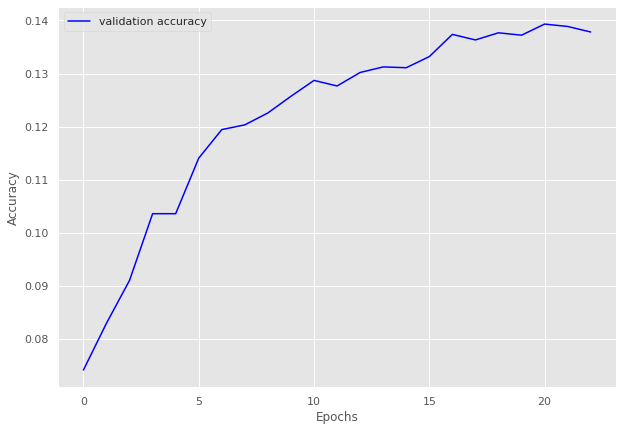

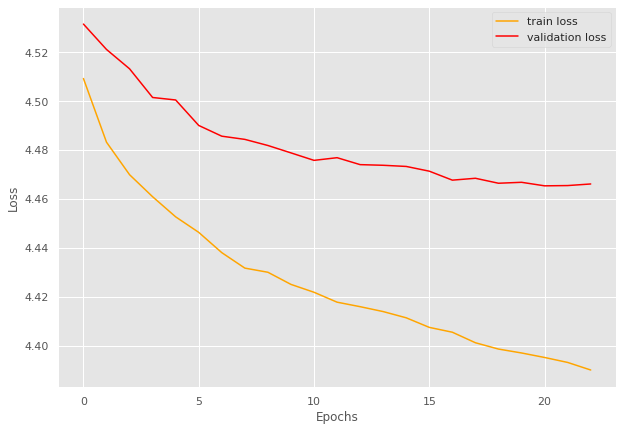

defaultdict(None, {'0': defaultdict(None, {'0': 0.7559430522790637, '10': 0.770031509312569, '20': 0.7847468531929986, '30': 0.7636471616873154, '50': 0.7221571506343105, '80': 0.6524077404028573})})
1 0
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.1] 
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.099570918899072, validation loss 4.008738808906996, validation accuracy 0.598355754857997
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.94]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.94346371077766, validation loss 3.951219739822241, validation accuracy 0.6521674140508221
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.89]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.893968672353505, validation loss 3.9254669042734, validation accuracy 0.6784753363228699
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [07:48<00:00,  2.24batch/s, loss=3.87]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8681013881027018, validation loss 3.904823598953394, validation accuracy 0.6974588938714499
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.85]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.84807199126414, validation loss 3.881561027123378, validation accuracy 0.7212257100149477
Epoch 6
-------------------------------


 79%|███████▉  | 835/1052 [04:52<01:12,  2.99batch/s, loss=3.83]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1052/1052 [07:51<00:00,  2.23batch/s, loss=3.81]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8075716173694163, validation loss 3.857422017134153, validation accuracy 0.7451420029895366
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.8]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.798332808362214, validation loss 3.848512039734767, validation accuracy 0.7533632286995515
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.79]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.7938076418615565, validation loss 3.8447683659883647, validation accuracy 0.7565022421524664
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [07:50<00:00,  2.24batch/s, loss=3.78]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.783105030939153, validation loss 3.8408945134052863, validation accuracy 0.75949177877429
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.78]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.7792278512349147, validation loss 3.837590066286234, validation accuracy 0.7632286995515695
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.77]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.7741155220981786, validation loss 3.830137236760213, validation accuracy 0.7715994020926756
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [06:09<00:00,  2.85batch/s, loss=3.76]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.763250654641213, validation loss 3.819889391844089, validation accuracy 0.7816143497757847
Epoch 15
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.75]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.7531754510484268, validation loss 3.8126367261776557, validation accuracy 0.7893871449925262
Epoch 16
-------------------------------


100%|██████████| 1052/1052 [07:50<00:00,  2.24batch/s, loss=3.75]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.7487855664677494, validation loss 3.8087776119892416, validation accuracy 0.7925261584454409
Epoch 17
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.87batch/s, loss=3.75]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.7464640718449203, validation loss 3.8073693169997287, validation accuracy 0.7940209267563527
Epoch 18
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.87batch/s, loss=3.74]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 1 of 5
train loss 3.74298668791586, validation loss 3.809399054600642, validation accuracy 0.7925261584454409
Epoch 19
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.74]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 2 of 5
train loss 3.7410892535978397, validation loss 3.8093900199119863, validation accuracy 0.791778774289985
Epoch 20
-------------------------------


100%|██████████| 1052/1052 [07:47<00:00,  2.25batch/s, loss=3.74]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 3 of 5
train loss 3.7410708919677442, validation loss 3.807688442560343, validation accuracy 0.7937219730941704
Epoch 21
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.74]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 4 of 5
train loss 3.738690338433922, validation loss 3.8109055917996626, validation accuracy 0.7901345291479821
Epoch 22
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.74]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.7361761827885878, validation loss 3.8049283692469964, validation accuracy 0.7968609865470851
Epoch 23
-------------------------------


100%|██████████| 1052/1052 [06:10<00:00,  2.84batch/s, loss=3.73]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.7342398493008924, validation loss 3.8015611194647274, validation accuracy 0.7992526158445441
Epoch 24
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.73]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 5 of 5
INFO: Early stopping


<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Done! Saved model with test accuracy 0.7930613524258872 and loss 3.7741029380870845


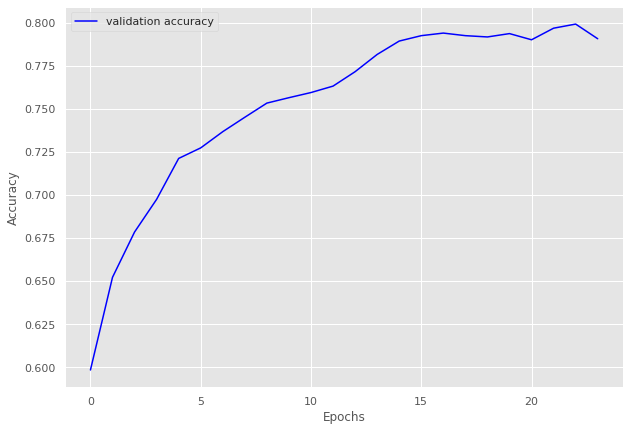

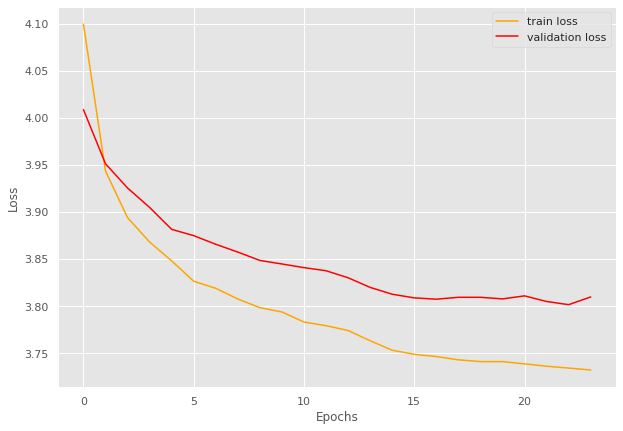

defaultdict(None, {'0': defaultdict(None, {'0': 0.7559430522790637, '10': 0.770031509312569, '20': 0.7847468531929986, '30': 0.7636471616873154, '50': 0.7221571506343105, '80': 0.6524077404028573}), '1': defaultdict(None, {'0': 0.7930613524258872})})
1 10
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.16]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.159345208012106, validation loss 4.088300005747722, validation accuracy 0.5171898355754858
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [07:50<00:00,  2.24batch/s, loss=4.02]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.021307960209285, validation loss 4.031718822625967, validation accuracy 0.5726457399103139
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [06:07<00:00,  2.86batch/s, loss=3.98]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9810400616533403, validation loss 4.011523535618415, validation accuracy 0.5920777279521674
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.95]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9546397131205513, validation loss 3.98562860259643, validation accuracy 0.6171898355754858
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [07:48<00:00,  2.24batch/s, loss=3.93]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.930437243256732, validation loss 3.9700086368964267, validation accuracy 0.6324364723467862
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.91]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9144972918604717, validation loss 3.9617226146734676, validation accuracy 0.6411061285500748
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.9]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9025735311181826, validation loss 3.9476345548262963, validation accuracy 0.6541106128550075
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [06:09<00:00,  2.85batch/s, loss=3.89]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8870764281813184, validation loss 3.9325438921268168, validation accuracy 0.6692077727952167
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [07:47<00:00,  2.25batch/s, loss=3.88]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8793086405036115, validation loss 3.9282683661350837, validation accuracy 0.6736920777279521
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.88]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8752448300445033, validation loss 3.9266408796493826, validation accuracy 0.6757847533632287
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.89batch/s, loss=3.87]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8712339893040095, validation loss 3.926513502231011, validation accuracy 0.6756352765321375
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.87]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8668000009123364, validation loss 3.9163076808819404, validation accuracy 0.6860986547085202
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [07:45<00:00,  2.26batch/s, loss=3.86]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.857339846770573, validation loss 3.913292109966278, validation accuracy 0.6890881913303438
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.86]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8552728587683616, validation loss 3.9088875765983877, validation accuracy 0.6928251121076233
Epoch 15
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.85]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.845925979514539, validation loss 3.9008260529774885, validation accuracy 0.7007473841554559
Epoch 16
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.84]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8364097940604496, validation loss 3.89502097093142, validation accuracy 0.7071748878923767
Epoch 17
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.83]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.825972378933838, validation loss 3.8873489797115326, validation accuracy 0.7143497757847533
Epoch 18
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.82]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 1 of 5
train loss 3.8205652962166092, validation loss 3.88743227491012, validation accuracy 0.7143497757847533
Epoch 19
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.87batch/s, loss=3.82]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8155423248675384, validation loss 3.8801005482673645, validation accuracy 0.7215246636771301
Epoch 23
-------------------------------


100%|██████████| 1052/1052 [07:49<00:00,  2.24batch/s, loss=3.81]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 3 of 5
train loss 3.812377562994286, validation loss 3.885873643251566, validation accuracy 0.7150971599402093
Epoch 24
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=3.81]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 4 of 5
train loss 3.812917940970156, validation loss 3.882716091779562, validation accuracy 0.7186846038863977
Epoch 25
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.81]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 5 of 5
INFO: Early stopping


<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Done! Saved model with test accuracy 0.7959153372816207 and loss 3.7710195272500058


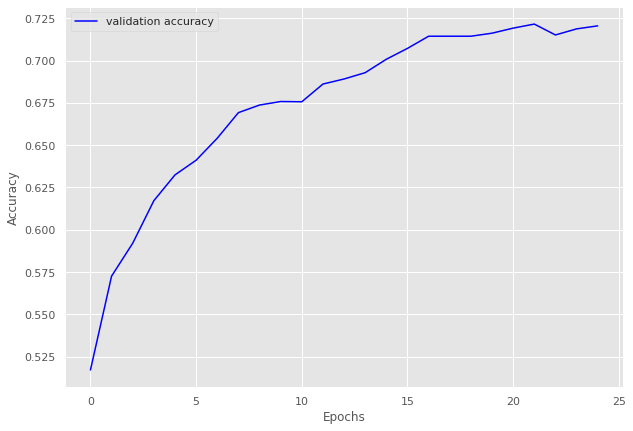

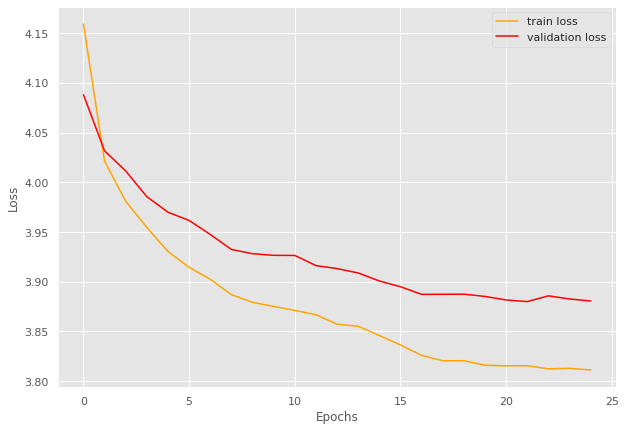

defaultdict(None, {'0': defaultdict(None, {'0': 0.7559430522790637, '10': 0.770031509312569, '20': 0.7847468531929986, '30': 0.7636471616873154, '50': 0.7221571506343105, '80': 0.6524077404028573}), '1': defaultdict(None, {'0': 0.7930613524258872, '10': 0.7959153372816207})})
1 20
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.19]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.1930076375660335, validation loss 4.123085588216782, validation accuracy 0.4820627802690583
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [07:49<00:00,  2.24batch/s, loss=4.08]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.075461365650815, validation loss 4.09314551949501, validation accuracy 0.5110612855007474
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.05]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.052584843717147, validation loss 4.082199908219851, validation accuracy 0.5218236173393124
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4.04]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.036139053536912, validation loss 4.072988491791945, validation accuracy 0.5310911808669656
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=4.03]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.0279577356327625, validation loss 4.067595963294689, validation accuracy 0.5360239162929746
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.02]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.015823543978281, validation loss 4.039547945444401, validation accuracy 0.5650224215246636
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [07:51<00:00,  2.23batch/s, loss=4]  
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9958772360145365, validation loss 4.036069750785828, validation accuracy 0.5675635276532137
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.99]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 1 of 5
train loss 3.988199222903741, validation loss 4.038285023891008, validation accuracy 0.5659192825112107
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [06:09<00:00,  2.85batch/s, loss=3.98]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.98089473941027, validation loss 4.035239315949953, validation accuracy 0.5687593423019432
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [07:45<00:00,  2.26batch/s, loss=3.98]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.975786151768137, validation loss 4.023775942050493, validation accuracy 0.5796711509715994
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [06:07<00:00,  2.87batch/s, loss=3.96]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.964297861200775, validation loss 4.020687882716839, validation accuracy 0.5831091180866965
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=3.96]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.956719814371247, validation loss 4.013763260382873, validation accuracy 0.589237668161435
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.95]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9510154406834013, validation loss 4.005384598787014, validation accuracy 0.5980568011958146
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.89batch/s, loss=3.94]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.941118831643587, validation loss 3.999272951712975, validation accuracy 0.6034379671150971
Epoch 15
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.94]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.935119853273544, validation loss 3.994670358987955, validation accuracy 0.6077727952167414
Epoch 16
-------------------------------


100%|██████████| 1052/1052 [07:44<00:00,  2.27batch/s, loss=3.93]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 2 of 5
train loss 3.934712113536356, validation loss 3.99741641833232, validation accuracy 0.604932735426009
Epoch 17
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.93]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9334162580196397, validation loss 3.9871221413979163, validation accuracy 0.614798206278027
Epoch 18
-------------------------------


100%|██████████| 1052/1052 [06:09<00:00,  2.85batch/s, loss=3.92]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9241188728310763, validation loss 3.981458109158736, validation accuracy 0.6212257100149476
Epoch 19
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.92]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9169476199965967, validation loss 3.9811298984747667, validation accuracy 0.6213751868460389
Epoch 20
-------------------------------


100%|██████████| 1052/1052 [07:45<00:00,  2.26batch/s, loss=3.91]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 3 of 5
train loss 3.913971420023378, validation loss 3.9823511105317335, validation accuracy 0.6201793721973095
Epoch 21
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=3.91]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.912738244796434, validation loss 3.978549989370199, validation accuracy 0.6234678624813154
Epoch 22
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.91]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9108265579426695, validation loss 3.9782439928788405, validation accuracy 0.6237668161434977
Epoch 23
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=3.91]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 4 of 5
train loss 3.9090159662322854, validation loss 3.9797092446914086, validation accuracy 0.6213751868460389
Epoch 24
-------------------------------


100%|██████████| 1052/1052 [07:38<00:00,  2.29batch/s, loss=3.91]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.906199361208274, validation loss 3.9728353229852824, validation accuracy 0.6292974588938715
Epoch 25
-------------------------------


100%|██████████| 1052/1052 [06:04<00:00,  2.88batch/s, loss=3.91]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 5 of 5
INFO: Early stopping


<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Done! Saved model with test accuracy 0.7745022023524754 and loss 3.792492191290528


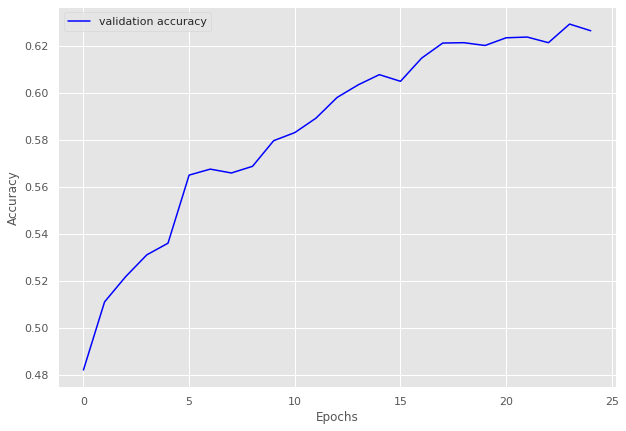

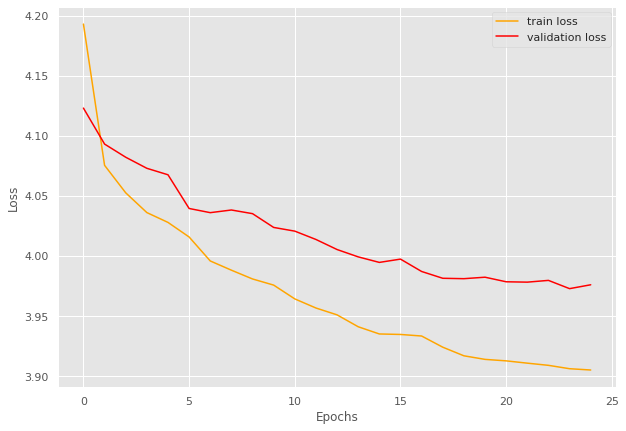

defaultdict(None, {'0': defaultdict(None, {'0': 0.7559430522790637, '10': 0.770031509312569, '20': 0.7847468531929986, '30': 0.7636471616873154, '50': 0.7221571506343105, '80': 0.6524077404028573}), '1': defaultdict(None, {'0': 0.7930613524258872, '10': 0.7959153372816207, '20': 0.7745022023524754})})
1 30
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [06:09<00:00,  2.85batch/s, loss=4.25]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.250565025289703, validation loss 4.210289127551592, validation accuracy 0.39342301943198804
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [07:47<00:00,  2.25batch/s, loss=4.16]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.1575144270980315, validation loss 4.169686808035924, validation accuracy 0.4348281016442451
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4.12]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.122290745207565, validation loss 4.141211326305683, validation accuracy 0.4629297458893871
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.1]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.103029228888537, validation loss 4.135871573136403, validation accuracy 0.46846038863976086
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [06:06<00:00,  2.87batch/s, loss=4.09]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.089985949005011, validation loss 4.124055775312277, validation accuracy 0.47922272047832587
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [07:46<00:00,  2.26batch/s, loss=4.07]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.072765685986203, validation loss 4.103232693213683, validation accuracy 0.5001494768310912
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.06]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.055208031895496, validation loss 4.084686900560673, validation accuracy 0.519880418535127
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.05]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.048111214383927, validation loss 4.078303625950446, validation accuracy 0.5258594917787743
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.04]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.036739896912085, validation loss 4.075932202430872, validation accuracy 0.5279521674140508
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [06:10<00:00,  2.84batch/s, loss=4.03]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 1 of 5
train loss 4.032933185988959, validation loss 4.079726831271098, validation accuracy 0.523168908819133
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.03]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.029512697526258, validation loss 4.075897785333487, validation accuracy 0.5266068759342302
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [07:48<00:00,  2.25batch/s, loss=4.02]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.02487255502563, validation loss 4.072618042047207, validation accuracy 0.5292974588938715
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.02]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.020742747266937, validation loss 4.068463350717838, validation accuracy 0.5351270553064275
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.02]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.017423752822803, validation loss 4.067806262236375, validation accuracy 0.5357249626307923
Epoch 15
-------------------------------


100%|██████████| 1052/1052 [06:05<00:00,  2.88batch/s, loss=4.01]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.011604716342665, validation loss 4.065288967811144, validation accuracy 0.5385650224215247
Epoch 16
-------------------------------


100%|██████████| 1052/1052 [07:49<00:00,  2.24batch/s, loss=4.01]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.006989821508357, validation loss 4.057576599029394, validation accuracy 0.544693572496263
Epoch 17
-------------------------------


100%|██████████| 1052/1052 [07:45<00:00,  2.26batch/s, loss=3.84]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 3 of 5
train loss 3.8412082328995822, validation loss 3.9079375060705037, validation accuracy 0.6926756352765321
Epoch 21
-------------------------------


100%|██████████| 1052/1052 [06:12<00:00,  2.82batch/s, loss=3.84]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 4 of 5
train loss 3.839681945826164, validation loss 3.9086472392082214, validation accuracy 0.6935724962630793
Epoch 22
-------------------------------


100%|██████████| 1052/1052 [07:24<00:00,  2.37batch/s, loss=3.84]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 5 of 5
INFO: Early stopping


<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Done! Saved model with test accuracy 0.7649009353811637 and loss 3.802548720441373


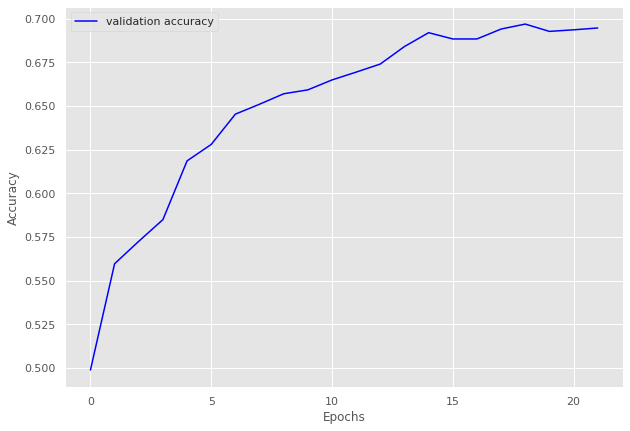

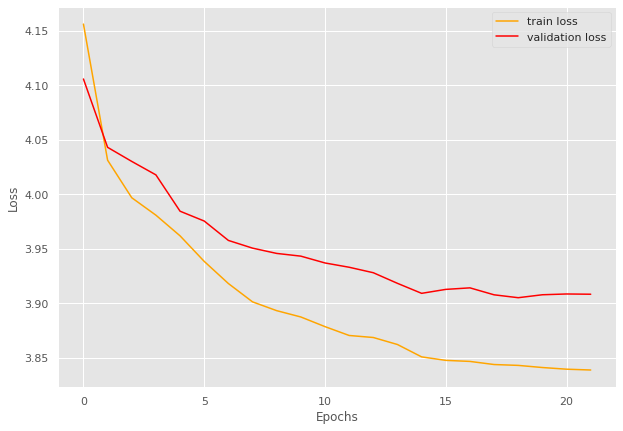

defaultdict(None, {'0': defaultdict(None, {'0': 0.7559430522790637, '10': 0.770031509312569, '20': 0.7847468531929986, '30': 0.7636471616873154, '50': 0.7221571506343105, '80': 0.6524077404028573}), '1': defaultdict(None, {'0': 0.7930613524258872, '10': 0.7959153372816207, '20': 0.7745022023524754, '30': 0.7806555916657043, '50': 0.7256050282923933, '80': 0.645792434465579}), '2': defaultdict(None, {'0': 0.7881287427619315, '10': 0.7649009353811637})})
2 20
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.2] 
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.204213660252865, validation loss 4.132683180845701, validation accuracy 0.4730941704035874
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [06:19<00:00,  2.77batch/s, loss=4.07]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.073908000391246, validation loss 4.090336348001774, validation accuracy 0.5142002989536621
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.04]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.036848547567433, validation loss 4.080596373631404, validation accuracy 0.5224215246636771
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [07:57<00:00,  2.21batch/s, loss=4.02]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.024228447743695, validation loss 4.0646036588228664, validation accuracy 0.5397608370702541
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [06:16<00:00,  2.79batch/s, loss=4.01]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.012058333978906, validation loss 4.056542357573142, validation accuracy 0.5476831091180867
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [06:20<00:00,  2.77batch/s, loss=4]  
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.002765213808632, validation loss 4.054415929775971, validation accuracy 0.5485799701046338
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [06:19<00:00,  2.78batch/s, loss=3.99]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9937483758980785, validation loss 4.035604139933219, validation accuracy 0.5674140508221226
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [06:17<00:00,  2.79batch/s, loss=3.98]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 1 of 5
train loss 3.984896933397866, validation loss 4.039266042984449, validation accuracy 0.5645739910313902
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [06:43<00:00,  2.61batch/s, loss=3.98]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9796847241006423, validation loss 4.030880022507447, validation accuracy 0.5726457399103139
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [07:02<00:00,  2.49batch/s, loss=3.97]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.967443407488413, validation loss 4.017851430636186, validation accuracy 0.5841554559043348
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=3.95]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9546126462660816, validation loss 4.008580173437412, validation accuracy 0.5944693572496264
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=3.95]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 2 of 5
train loss 3.948995024305786, validation loss 4.010160698340489, validation accuracy 0.592526158445441
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [08:01<00:00,  2.19batch/s, loss=3.94]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.944007709905675, validation loss 4.00303023136579, validation accuracy 0.5986547085201793
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [06:31<00:00,  2.69batch/s, loss=3.94]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 3 of 5
train loss 3.940279149510561, validation loss 4.005750436049241, validation accuracy 0.5973094170403588
Epoch 15
-------------------------------


100%|██████████| 1052/1052 [06:22<00:00,  2.75batch/s, loss=3.94]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.935882505355226, validation loss 3.9958948355454664, validation accuracy 0.6064275037369208
Epoch 16
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=3.93]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.930451297714683, validation loss 3.9958460422662587, validation accuracy 0.6062780269058295
Epoch 17
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=3.93]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9273698001306774, validation loss 3.9945394626030555, validation accuracy 0.6077727952167414
Epoch 18
-------------------------------


100%|██████████| 1052/1052 [06:17<00:00,  2.79batch/s, loss=3.92]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 4 of 5
train loss 3.9239729241726518, validation loss 3.9954702028861413, validation accuracy 0.6056801195814648
Epoch 19
-------------------------------


100%|██████████| 1052/1052 [08:00<00:00,  2.19batch/s, loss=3.92]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9228065671123025, validation loss 3.9920133512753706, validation accuracy 0.6104633781763826
Epoch 20
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=3.92]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.9217036545503277, validation loss 3.9900048879476695, validation accuracy 0.612406576980568
Epoch 21
-------------------------------


100%|██████████| 1052/1052 [06:56<00:00,  2.53batch/s, loss=3.92]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 5 of 5
INFO: Early stopping


<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Done! Saved model with test accuracy 0.7602157810515202 and loss 3.806925543258409


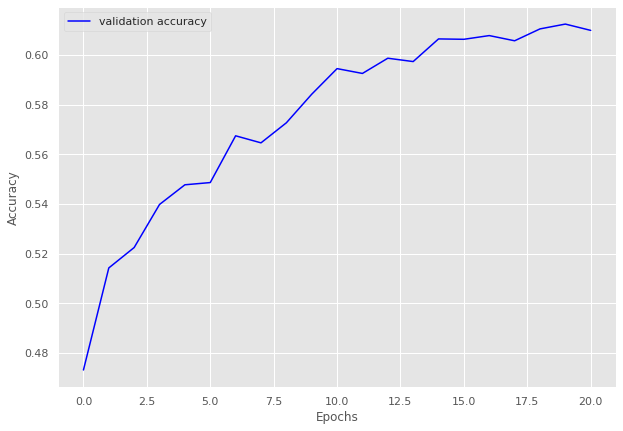

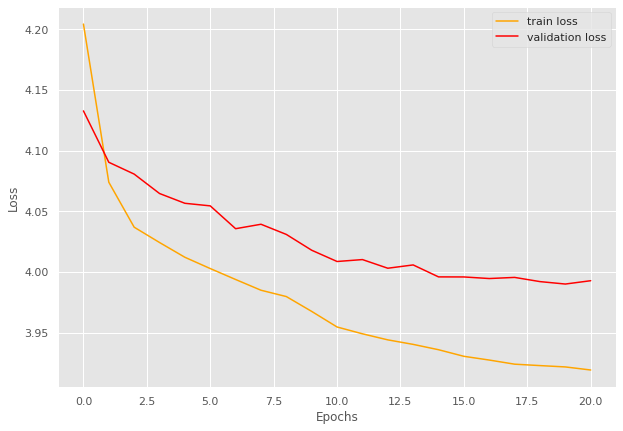

defaultdict(None, {'0': defaultdict(None, {'0': 0.7559430522790637, '10': 0.770031509312569, '20': 0.7847468531929986, '30': 0.7636471616873154, '50': 0.7221571506343105, '80': 0.6524077404028573}), '1': defaultdict(None, {'0': 0.7930613524258872, '10': 0.7959153372816207, '20': 0.7745022023524754, '30': 0.7806555916657043, '50': 0.7256050282923933, '80': 0.645792434465579}), '2': defaultdict(None, {'0': 0.7881287427619315, '10': 0.7649009353811637, '20': 0.7602157810515202})})
2 30
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [06:17<00:00,  2.79batch/s, loss=4.25]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.2498831195976345, validation loss 4.219046938877839, validation accuracy 0.3860986547085202
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [06:21<00:00,  2.76batch/s, loss=4.17]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.166885084978981, validation loss 4.178705518062298, validation accuracy 0.4260089686098655
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.13]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.128573393187142, validation loss 4.173226452790773, validation accuracy 0.4307922272047833
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [07:57<00:00,  2.20batch/s, loss=4.11]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.114311566597609, validation loss 4.1460809638867016, validation accuracy 0.4587443946188341
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.1]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.097802011459046, validation loss 4.142143978522374, validation accuracy 0.46278026905829595
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [06:17<00:00,  2.79batch/s, loss=4.08]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.084228382137792, validation loss 4.130931840493129, validation accuracy 0.47219730941704036
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [06:17<00:00,  2.79batch/s, loss=4.07]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.071209456304181, validation loss 4.1224608696424045, validation accuracy 0.4808669656203288
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.07]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.06645718182901, validation loss 4.121234847949101, validation accuracy 0.48236173393124065
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [06:16<00:00,  2.80batch/s, loss=4.06]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.0618812725117905, validation loss 4.115430400921748, validation accuracy 0.48774289985052316
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [07:58<00:00,  2.20batch/s, loss=4.06]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.055842165257994, validation loss 4.1125398599184475, validation accuracy 0.4904334828101644
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [06:20<00:00,  2.77batch/s, loss=4.05]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.049601671133658, validation loss 4.110538462033639, validation accuracy 0.49312406576980566
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.05]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.04724989531158, validation loss 4.101115598128392, validation accuracy 0.5026905829596413
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.04]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 1 of 5
train loss 4.038917633743794, validation loss 4.107563798244183, validation accuracy 0.49671150971599404
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [07:56<00:00,  2.21batch/s, loss=4.04]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.036645259240735, validation loss 4.096960459764187, validation accuracy 0.5055306427503737
Epoch 15
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.03]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.032678314034929, validation loss 4.0954363483649034, validation accuracy 0.5079222720478326
Epoch 16
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.03]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.026165167188463, validation loss 4.089438232091757, validation accuracy 0.5134529147982063
Epoch 17
-------------------------------


100%|██████████| 1052/1052 [07:58<00:00,  2.20batch/s, loss=4.02]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 2 of 5
train loss 4.023034360018973, validation loss 4.092397944285319, validation accuracy 0.5104633781763827
Epoch 18
-------------------------------


100%|██████████| 1052/1052 [06:19<00:00,  2.77batch/s, loss=4.02]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.016627695397279, validation loss 4.081396098320301, validation accuracy 0.5216741405082213
Epoch 19
-------------------------------


100%|██████████| 1052/1052 [06:20<00:00,  2.76batch/s, loss=4.01]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 3 of 5
train loss 4.013972430628062, validation loss 4.082069876102301, validation accuracy 0.5201793721973094
Epoch 20
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.01]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 4 of 5
train loss 4.011607968081993, validation loss 4.084836038259359, validation accuracy 0.5177877428998505
Epoch 21
-------------------------------


100%|██████████| 1052/1052 [06:17<00:00,  2.78batch/s, loss=4.01]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 5 of 5
INFO: Early stopping


<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Done! Saved model with test accuracy 0.7399574376824983 and loss 3.8266005798025646


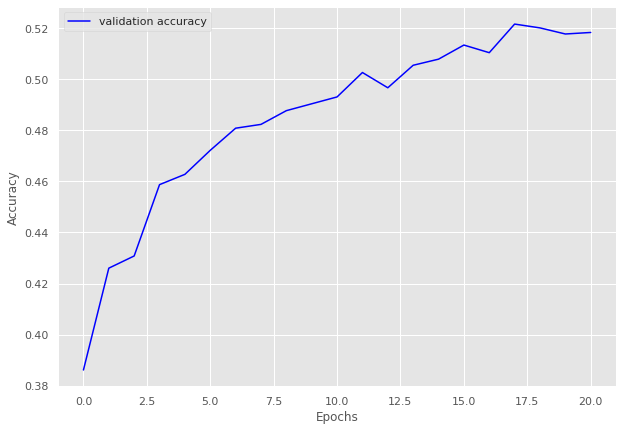

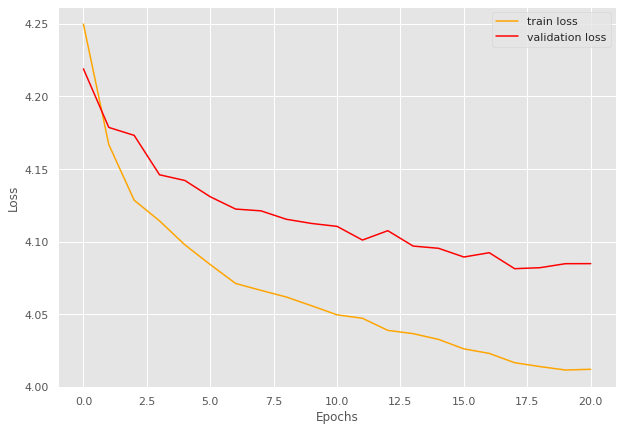

defaultdict(None, {'0': defaultdict(None, {'0': 0.7559430522790637, '10': 0.770031509312569, '20': 0.7847468531929986, '30': 0.7636471616873154, '50': 0.7221571506343105, '80': 0.6524077404028573}), '1': defaultdict(None, {'0': 0.7930613524258872, '10': 0.7959153372816207, '20': 0.7745022023524754, '30': 0.7806555916657043, '50': 0.7256050282923933, '80': 0.645792434465579}), '2': defaultdict(None, {'0': 0.7881287427619315, '10': 0.7649009353811637, '20': 0.7602157810515202, '30': 0.7399574376824983})})
2 50
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [07:59<00:00,  2.19batch/s, loss=4.37]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.367886187005859, validation loss 4.350704754774387, validation accuracy 0.2556053811659193
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [06:17<00:00,  2.78batch/s, loss=4.3]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.2956359721861865, validation loss 4.326310063783939, validation accuracy 0.2789237668161435
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.27]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.267102131825436, validation loss 4.295078128576279, validation accuracy 0.30971599402092675
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [06:19<00:00,  2.77batch/s, loss=4.25]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.2492450185601705, validation loss 4.2848984988836145, validation accuracy 0.3197309417040359
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [08:02<00:00,  2.18batch/s, loss=4.24]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.239963601750566, validation loss 4.281132370233536, validation accuracy 0.32301943198804184
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [06:20<00:00,  2.76batch/s, loss=4.23]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.231395038361785, validation loss 4.270730110315176, validation accuracy 0.33408071748878926
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.22]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.219990588412992, validation loss 4.259338947442862, validation accuracy 0.3439461883408072
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [07:54<00:00,  2.22batch/s, loss=4.21]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.211316026662239, validation loss 4.253597626319299, validation accuracy 0.3500747384155456
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [06:17<00:00,  2.78batch/s, loss=4.2]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.202119842228328, validation loss 4.252610699488566, validation accuracy 0.3508221225710015
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [06:20<00:00,  2.76batch/s, loss=4.2]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.196059926154495, validation loss 4.243293929558534, validation accuracy 0.36053811659192825
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [06:17<00:00,  2.78batch/s, loss=4.19]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 1 of 5
train loss 4.190861209943721, validation loss 4.244810205239516, validation accuracy 0.35979073243647236
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.19]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.1874351054996595, validation loss 4.241963407168021, validation accuracy 0.36233183856502243
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [07:58<00:00,  2.20batch/s, loss=4.18]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.1835437208527395, validation loss 4.23816588979501, validation accuracy 0.36606875934230193
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [06:16<00:00,  2.79batch/s, loss=4.18]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.177822311794803, validation loss 4.236206967097062, validation accuracy 0.3680119581464873
Epoch 15
-------------------------------


100%|██████████| 1052/1052 [06:21<00:00,  2.76batch/s, loss=4.18]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 2 of 5
train loss 4.1759127956379505, validation loss 4.236421715754729, validation accuracy 0.36756352765321376
Epoch 16
-------------------------------


100%|██████████| 1052/1052 [06:19<00:00,  2.77batch/s, loss=4.17]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 3 of 5
train loss 4.174261911966955, validation loss 4.236726240469859, validation accuracy 0.3672645739910314
Epoch 17
-------------------------------


100%|██████████| 1052/1052 [07:56<00:00,  2.21batch/s, loss=4.17]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.170512551817151, validation loss 4.23141991175138, validation accuracy 0.37294469357249627
Epoch 18
-------------------------------


100%|██████████| 1052/1052 [06:19<00:00,  2.77batch/s, loss=4.17]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 4 of 5
train loss 4.168159110691158, validation loss 4.234711954226861, validation accuracy 0.3696562032884903
Epoch 19
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.17]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 5 of 5
INFO: Early stopping


<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Done! Saved model with test accuracy 0.7168781035023178 and loss 3.8509115729689474


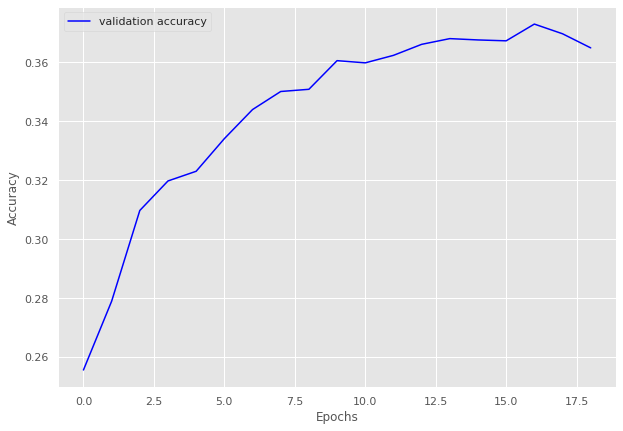

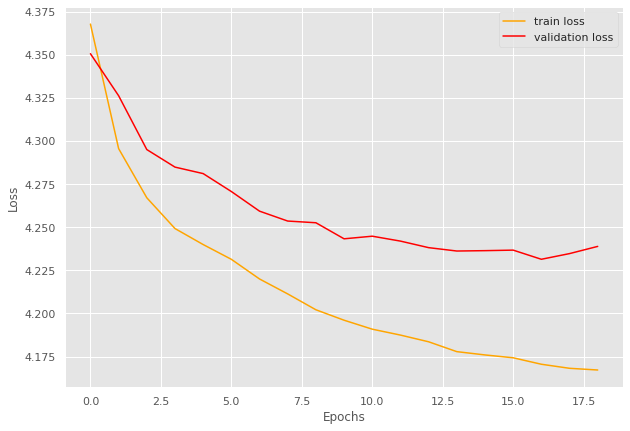

defaultdict(None, {'0': defaultdict(None, {'0': 0.7559430522790637, '10': 0.770031509312569, '20': 0.7847468531929986, '30': 0.7636471616873154, '50': 0.7221571506343105, '80': 0.6524077404028573}), '1': defaultdict(None, {'0': 0.7930613524258872, '10': 0.7959153372816207, '20': 0.7745022023524754, '30': 0.7806555916657043, '50': 0.7256050282923933, '80': 0.645792434465579}), '2': defaultdict(None, {'0': 0.7881287427619315, '10': 0.7649009353811637, '20': 0.7602157810515202, '30': 0.7399574376824983, '50': 0.7168781035023178})})
2 80
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [07:48<00:00,  2.24batch/s, loss=4.51]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.505331855763047, validation loss 4.536894944997934, validation accuracy 0.06801195814648729
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.49]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.488643888284952, validation loss 4.52361642397367, validation accuracy 0.08086696562032884
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [06:20<00:00,  2.77batch/s, loss=4.47]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.47249696327253, validation loss 4.505449900260339, validation accuracy 0.10119581464872944
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [06:19<00:00,  2.77batch/s, loss=4.46]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.458665897637719, validation loss 4.499673857138707, validation accuracy 0.10463378176382661
Epoch 5
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.45]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.448520527139816, validation loss 4.490543567217314, validation accuracy 0.11434977578475336
Epoch 6
-------------------------------


100%|██████████| 1052/1052 [08:00<00:00,  2.19batch/s, loss=4.44]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.441423296475138, validation loss 4.48568364748588, validation accuracy 0.11913303437967115
Epoch 7
-------------------------------


100%|██████████| 1052/1052 [06:19<00:00,  2.77batch/s, loss=4.44]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.43658921156546, validation loss 4.48068289573376, validation accuracy 0.12481315396113603
Epoch 8
-------------------------------


100%|██████████| 1052/1052 [06:19<00:00,  2.77batch/s, loss=4.43]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 1 of 5
train loss 4.431682139295136, validation loss 4.480891168117523, validation accuracy 0.12436472346786248
Epoch 9
-------------------------------


100%|██████████| 1052/1052 [06:19<00:00,  2.77batch/s, loss=4.43]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.426737243231711, validation loss 4.476092219352722, validation accuracy 0.1289985052316891
Epoch 10
-------------------------------


100%|██████████| 1052/1052 [07:58<00:00,  2.20batch/s, loss=4.42]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.423250727327151, validation loss 4.474628081688514, validation accuracy 0.13064275037369208
Epoch 11
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.42]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.421204856593346, validation loss 4.474143738930042, validation accuracy 0.13079222720478326
Epoch 12
-------------------------------


100%|██████████| 1052/1052 [06:21<00:00,  2.76batch/s, loss=4.42]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.417284489131246, validation loss 4.466583151083726, validation accuracy 0.13856502242152466
Epoch 13
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.41]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.41330150551669, validation loss 4.466468811035156, validation accuracy 0.1382660687593423
Epoch 14
-------------------------------


100%|██████████| 1052/1052 [06:17<00:00,  2.79batch/s, loss=4.41]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.409300080723636, validation loss 4.465497961411109, validation accuracy 0.14005979073243646
Epoch 15
-------------------------------


100%|██████████| 1052/1052 [06:19<00:00,  2.77batch/s, loss=4.41]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 2 of 5
train loss 4.406919291264204, validation loss 4.46676564675111, validation accuracy 0.13781763826606877
Epoch 16
-------------------------------


100%|██████████| 1052/1052 [07:41<00:00,  2.28batch/s, loss=4.4]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 3 of 5
train loss 4.404576373644201, validation loss 4.465949397820693, validation accuracy 0.13871449925261584
Epoch 17
-------------------------------


100%|██████████| 1052/1052 [06:19<00:00,  2.77batch/s, loss=4.4]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.4022761823559895, validation loss 4.464985819963308, validation accuracy 0.13931240657698057
Epoch 18
-------------------------------


100%|██████████| 1052/1052 [07:59<00:00,  2.19batch/s, loss=4.4]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.399233131807566, validation loss 4.464134431802309, validation accuracy 0.14020926756352764
Epoch 19
-------------------------------


100%|██████████| 1052/1052 [06:19<00:00,  2.77batch/s, loss=4.4]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.397630933573038, validation loss 4.4639065861701965, validation accuracy 0.14095665171898356
Epoch 20
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.4]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.395569045734043, validation loss 4.462256537033961, validation accuracy 0.14200298953662183
Epoch 21
-------------------------------


100%|██████████| 1052/1052 [06:21<00:00,  2.76batch/s, loss=4.39]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 4 of 5
train loss 4.394797787466883, validation loss 4.464700685097621, validation accuracy 0.13991031390134528
Epoch 22
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.39]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.392073575988015, validation loss 4.461839547524085, validation accuracy 0.1430493273542601
Epoch 23
-------------------------------


100%|██████████| 1052/1052 [06:17<00:00,  2.78batch/s, loss=4.39]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


INFO: Early stopping counter 5 of 5
INFO: Early stopping


<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Done! Saved model with test accuracy 0.6567134632198888 and loss 3.913759078244347


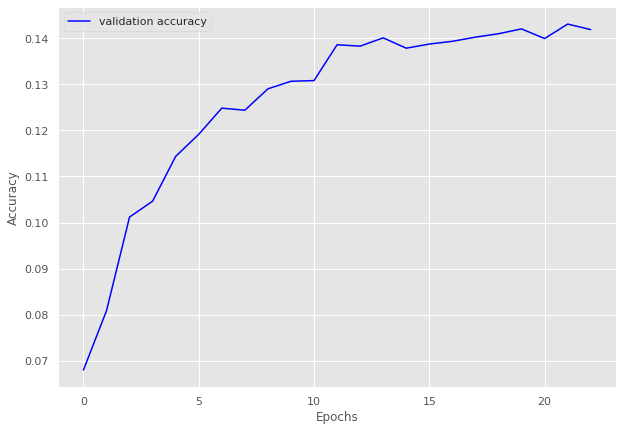

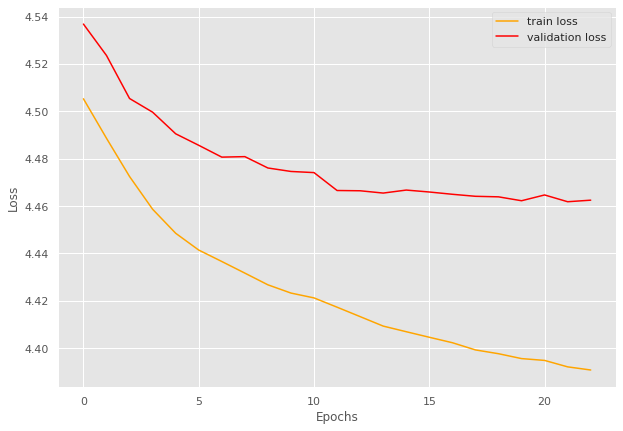

defaultdict(None, {'0': defaultdict(None, {'0': 0.7559430522790637, '10': 0.770031509312569, '20': 0.7847468531929986, '30': 0.7636471616873154, '50': 0.7221571506343105, '80': 0.6524077404028573}), '1': defaultdict(None, {'0': 0.7930613524258872, '10': 0.7959153372816207, '20': 0.7745022023524754, '30': 0.7806555916657043, '50': 0.7256050282923933, '80': 0.645792434465579}), '2': defaultdict(None, {'0': 0.7881287427619315, '10': 0.7649009353811637, '20': 0.7602157810515202, '30': 0.7399574376824983, '50': 0.7168781035023178, '80': 0.6567134632198888})})
3 0
Epoch 1
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=4.09]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 4.091846944261413, validation loss 4.002507049303788, validation accuracy 0.6028400597907324
Epoch 2
-------------------------------


100%|██████████| 1052/1052 [06:18<00:00,  2.78batch/s, loss=3.93]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.928744524604014, validation loss 3.9339704628174124, validation accuracy 0.6707025411061286
Epoch 3
-------------------------------


100%|██████████| 1052/1052 [07:58<00:00,  2.20batch/s, loss=3.88]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8835109667179704, validation loss 3.921915049736316, validation accuracy 0.6820627802690583
Epoch 4
-------------------------------


100%|██████████| 1052/1052 [06:30<00:00,  2.69batch/s, loss=3.86]
<ipython-input-2-f9de9bfe5dc1>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


train loss 3.8595561818024957, validation loss 3.9084231486687293, validation accuracy 0.6964125560538117
Epoch 5
-------------------------------


 21%|██        | 219/1052 [01:19<05:10,  2.68batch/s, loss=3.84]

In [ ]:
for run, seed in enumerate(seeds):
    #set manual seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    flat_accuracies['%s' %run] = defaultdict()
    
    #prepare data
    train_df = df[df['split_%s' %(run)] == 'train']
    test_df = df[df['split_%s' %(run)] == 'test']
    valid_df = df[df['split_%s' %(run)] == 'valid']
    

    for volume in label_noises:
        print(run, volume)

        # prepare dataloaders
        batch_size = 64

        test_dataset = IconDataset(test_df, test_transform, "", run, volume)
        train_dataset = IconDataset(train_df, train_transform, "", run, volume)
        validation_dataset = IconDataset(valid_df, test_transform, "", run, volume)

        dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        dl_valid = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

        # train flat model 
        gc.collect() 
        torch.cuda.empty_cache()
        epochs= 40

        model = Resnext50(n_classes, name="flat_model_Resnext50_icons_noise_50_training_%s_%s" %(volume, run))
        model.state_dict(torch.load(fine_tuned_model_path))               
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        model.to(device)
        loss_fn = torch.nn.CrossEntropyLoss().to(device)

        test_accuracy =train_and_validate(epochs, model, loss_fn, optimizer, 
                                                            dl_train, dl_test, dl_valid,
                                                            model_path = teamdrive_root + '/models/base/%s.pth' %model.name )
        flat_accuracies['%s' %run]['%s' %volume] = test_accuracy
        print(flat_accuracies)
        with open(teamdrive_root + '/icons_experiment/flat_accuracies_noise_50_training_experiment.p', 'wb') as handle:
            pickle.dump(flat_accuracies, handle)

NameError: name 'flat_accuracies' is not defined